In [48]:
import tensorflow as tf
import tensorflow_datasets as tfds


# Load TF Flowers dataset


In [49]:
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

In [50]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Normalize and resize


In [51]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(1)

# Load MobileNetV2 and Build Model

In [52]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model

In [53]:
base_model.trainable = False  

In [54]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes
])

# Compile and Train the Model

In [55]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(ds_train, validation_data=ds_test, epochs=10)

Epoch 1/10


92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 524ms/step - accuracy: 0.6940 - loss: 0.7833 - val_accuracy: 0.8856 - val_loss: 0.3389
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 538ms/step - accuracy: 0.9214 - loss: 0.2439 - val_accuracy: 0.9019 - val_loss: 0.2965
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 548ms/step - accuracy: 0.9526 - loss: 0.1606 - val_accuracy: 0.9128 - val_loss: 0.2988
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 527ms/step - accuracy: 0.9759 - loss: 0.1071 - val_accuracy: 0.8896 - val_loss: 0.3218
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 535ms/step - accuracy: 0.9840 - loss: 0.0768 - val_accuracy: 0.9169 - val_loss: 0.3104
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 508ms/step - accuracy: 0.9913 - loss: 0.0454 - val_accuracy: 0.9128 - val_loss: 0.2926
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 578ms/step - accuracy: 0.9988 - loss: 0.0253 - val_accuracy: 0.9128 - val_loss: 0.3161
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 537ms/step - accuracy: 0.9990 - loss: 0.0215 - val_accuracy: 0.918

# Evaluate the Model

In [56]:
loss, accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {accuracy:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.9220 - loss: 0.3124
Test Accuracy: 0.92


In [57]:
# Unfreeze last 20 layers
N = 20
for layer in base_model.layers[-N:]:
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_a = model.fit(ds_train, validation_data=ds_test, epochs=5)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 619ms/step - accuracy: 0.8588 - loss: 0.3916 - val_accuracy: 0.9114 - val_loss: 0.3190
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 616ms/step - accuracy: 0.9371 - loss: 0.1719 - val_accuracy: 0.9101 - val_loss: 0.3138
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 637ms/step - accuracy: 0.9671 - loss: 0.1133 - val_accuracy: 0.9183 - val_loss: 0.3014
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 635ms/step - accuracy: 0.9695 - loss: 0.1062 - val_accuracy: 0.9196 - val_loss: 0.2985
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 640ms/step - accuracy: 0.9763 - loss: 0.0806 - val_accuracy: 0.9128 - val_loss: 0.2976


In [12]:
print(f"Trainable params: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])}")


Trainable params: 1370693


In [58]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,163,985 (19.70 MB)

 Trainable params: 1,370,693 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 2,741,388 (10.46 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


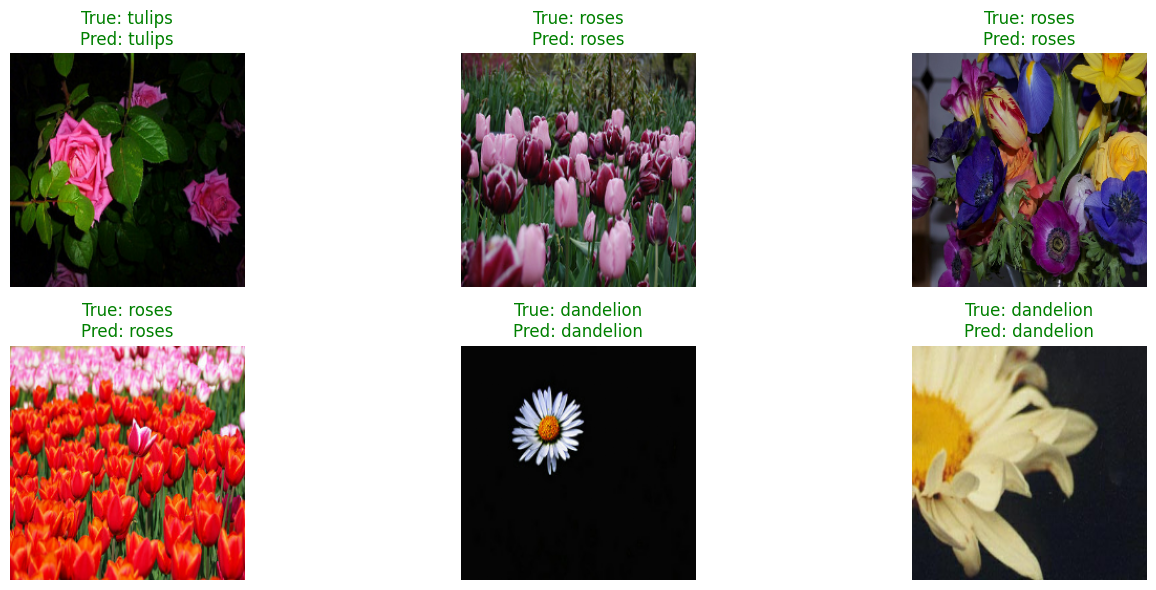

2025-04-09 19:40:52.743296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [59]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']  # TF Flowers classes

for images, labels in ds_test.take(1):
    preds = model.predict(images)
    pred_classes = tf.argmax(preds, axis=1)
    
    plt.figure(figsize=(15, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i])
        true = class_names[labels[i].numpy()]
        pred = class_names[pred_classes[i].numpy()]
        color = 'green' if true == pred else 'red'
        plt.title(f"True: {true}\nPred: {pred}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


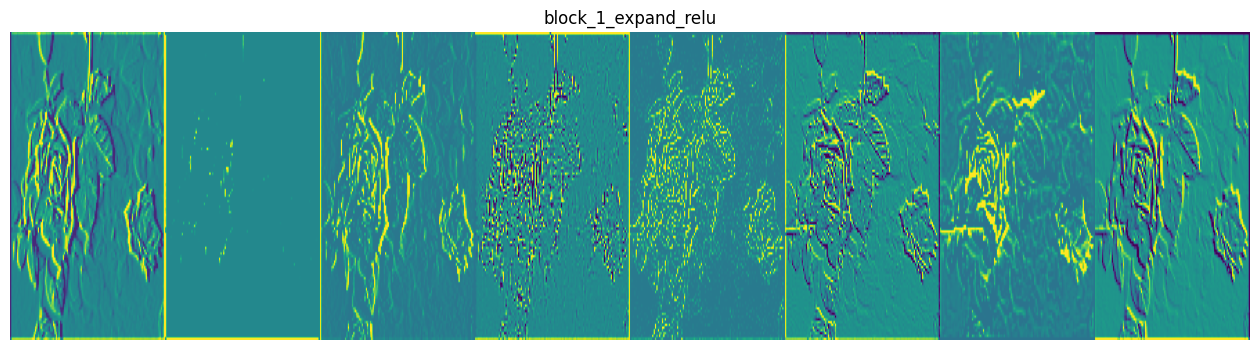

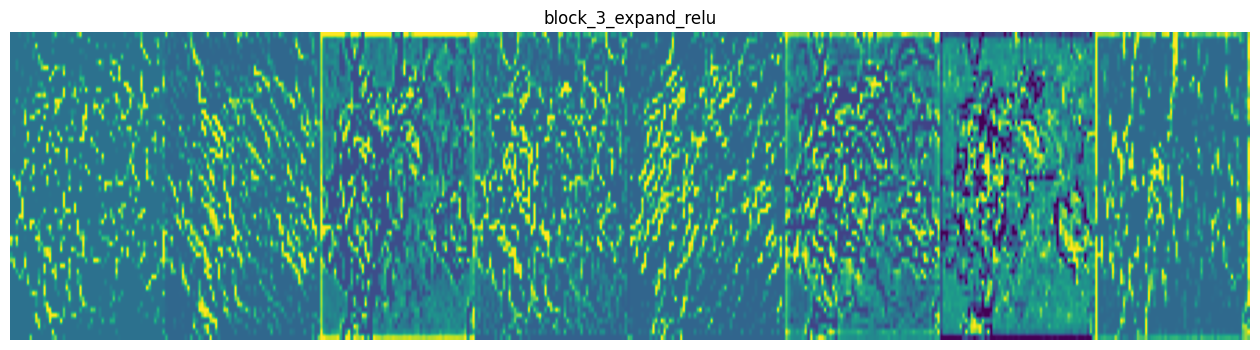

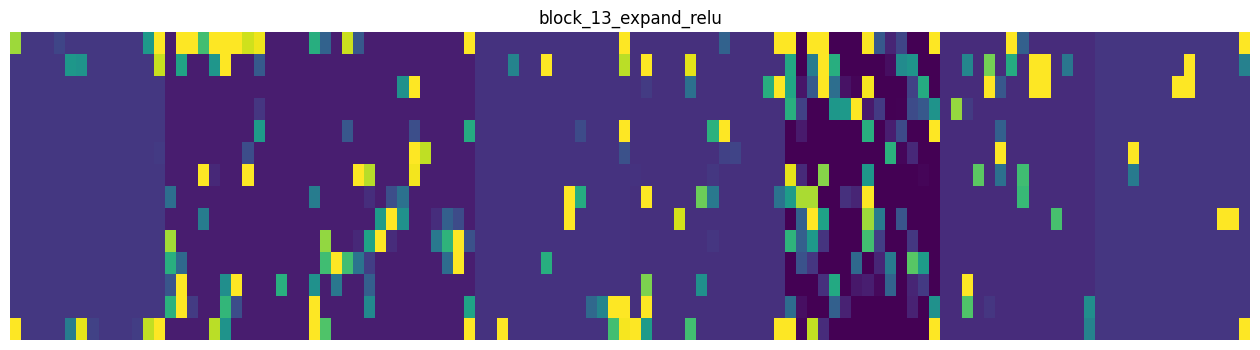

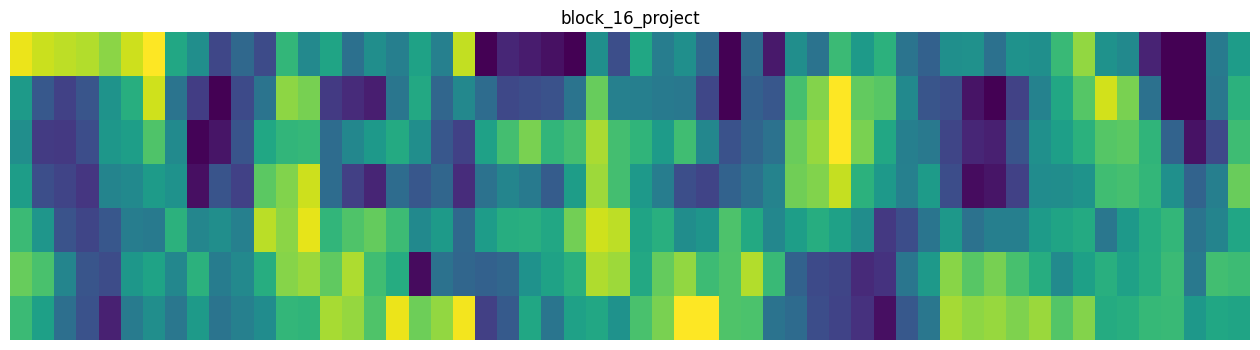

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

# Pick an image from your dataset
for image, label in ds_test.take(1):
    img = image[0]
    break

# Expand dims to add batch size
img_array = tf.expand_dims(img, axis=0)

# Choose some intermediate layers to visualize
layer_names = [
    'block_1_expand_relu',   # early layer
    'block_3_expand_relu',   # middle
    'block_13_expand_relu',  # deeper
    'block_16_project'       # last conv block
]

# Create model that outputs intermediate layers
outputs = [base_model.get_layer(name).output for name in layer_names]
feature_model = Model(inputs=base_model.input, outputs=outputs)



# Get feature maps
feature_maps = feature_model.predict(img_array)

# Plot feature maps from each selected layer
for fmap, layer_name in zip(feature_maps, layer_names):
    num_filters = fmap.shape[-1]
    size = fmap.shape[1]

    display_grid = np.zeros((size, size * 8))  # show 8 filters
    for i in range(8):
        x = fmap[0, :, :, i]
        x -= x.mean()
        x /= (x.std() + 1e-6)
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size: (i + 1) * size] = x

    plt.figure(figsize=(16, 4))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.axis('off')
    plt.show()


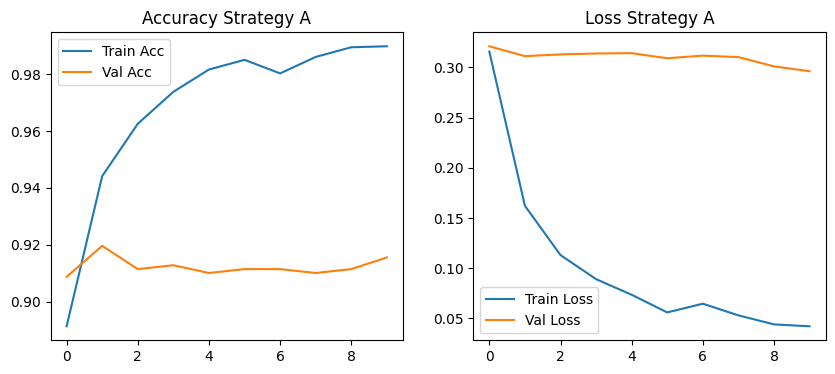

In [26]:
import matplotlib.pyplot as plt

def plot_history(hist, title=''):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy {title}')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f'Loss {title}')
    plt.legend()
    plt.show()

plot_history(history_a, 'Strategy A')


In [ ]:
# Refreeze everything first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze a full block range — say from block_13 onward
unfreeze = False
for layer in base_model.layers:
    if 'block_13' in layer.name:
        unfreeze = True
    if unfreeze:
        layer.trainable = True

# Recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_b = model.fit(ds_train, validation_data=ds_test, epochs=10)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 690ms/step - accuracy: 0.9635 - loss: 0.1014 - val_accuracy: 0.9142 - val_loss: 0.3111
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 699ms/step - accuracy: 0.9732 - loss: 0.0789 - val_accuracy: 0.9169 - val_loss: 0.3012
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 684ms/step - accuracy: 0.9809 - loss: 0.0675 - val_accuracy: 0.9142 - val_loss: 0.2997
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 686ms/step - accuracy: 0.9875 - loss: 0.0428 - val_accuracy: 0.9183 - val_loss: 0.2907
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 684ms/step - accuracy: 0.9923 - loss: 0.0351 - val_accuracy: 0.9169 - val_loss: 0.2867
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 691ms/step - accuracy: 0.9898 - loss: 0.0373 - val_accuracy: 0.9142 - val_loss: 0.2865
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 690ms/step - accuracy: 0.9957 - loss: 0.0247 - val_accuracy: 0.9183 - val_loss: 0.2914
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 690ms/step - accuracy: 0.9883 - loss: 0.0333 - val_accu

In [32]:
for i, layer in enumerate(base_model.layers):
    if 'block_13' in layer.name or 'block_14' in layer.name:
        print(i, layer.name)


116 block_13_expand
117 block_13_expand_BN
118 block_13_expand_relu
119 block_13_pad
120 block_13_depthwise
121 block_13_depthwise_BN
122 block_13_depthwise_relu
123 block_13_project
124 block_13_project_BN
125 block_14_expand
126 block_14_expand_BN
127 block_14_expand_relu
128 block_14_depthwise
129 block_14_depthwise_BN
130 block_14_depthwise_relu
131 block_14_project
132 block_14_project_BN
133 block_14_add


In [33]:
loss, acc = model.evaluate(ds_test)
print(f"Test Accuracy: {acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 507ms/step - accuracy: 0.9072 - loss: 0.3328
Test Accuracy: 0.9142
